In [3]:
import io
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import boto3
import sagemaker
from sagemaker import get_execution_role, PCA

In [4]:
session = sagemaker.Session()
print(session)

role = get_execution_role()
print(role)

bucket = session.default_bucket()

arn:aws:iam::240038582877:role/service-role/AmazonSageMaker-ExecutionRole-20191028T202433


In [5]:
# load data
prefix = 'segmentation'

data_key= prefix + '/azdias_scaled.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

In [6]:
tmp_list = []

for chunk in pd.read_csv(data_location, chunksize=100000):
    tmp_list.append(chunk)
    
df = pd.concat(tmp_list, axis=0).drop(['Unnamed: 0'], axis=1)
print(df.shape)
del tmp_list

(891221, 93)


In [7]:
df.head()

,LNR,AGER_TYP,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,...,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,VERS_TYP,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,0.806268,0.00,0.0,0.000000,1.000000,0.000000,0.000000,0.0,1.0,1.000000,...,0.500000,1.000000,0.166667,0.333333,0.0,0.00,0.000000,0.4,0.0,0.125
1,0.806273,0.00,0.0,0.000000,1.000000,0.000000,0.000000,0.0,1.0,1.000000,...,0.833333,0.500000,0.666667,0.833333,0.0,1.00,1.000000,0.8,1.0,0.000
2,0.806279,0.00,0.0,0.000000,1.000000,0.000000,0.000000,0.0,1.0,1.000000,...,0.500000,0.333333,0.500000,0.333333,0.5,0.75,0.666667,0.8,1.0,0.250
3,0.806280,0.75,0.0,0.000000,1.000000,0.000000,0.000000,0.0,1.0,1.000000,...,0.333333,0.166667,0.666667,0.500000,0.5,0.50,0.666667,0.4,1.0,0.375
4,0.806297,0.00,0.5,0.833333,0.444444,0.142857,0.333333,0.0,1.0,0.444444,...,0.166667,0.500000,0.833333,0.166667,1.0,0.75,1.000000,0.6,0.0,0.250


In [8]:
# prepare space to store model artifacts
prefix = 'pca'
output_path = 's3://{}/{}/'.format(bucket, prefix)
output_path

's3://sagemaker-us-east-2-240038582877/pca/'

In [9]:
N_COMPONENTS = 10
pca = PCA(role=role,
          train_instance_count=1,
          train_instance_type='ml.c4.xlarge',
          output_path=output_path,
          num_components=N_COMPONENTS,
          sagemaker_session=session)

In [10]:
#must convert to RecordSet for built in sagemaker models

#convert df to np array (pass this to the deployed PCA model later)
train_data_np = df.values.astype('float32')

#convert to RecordSet format
formatted_train_data = pca.record_set(train_data_np)

In [11]:
pca.fit(formatted_train_data)

2020-04-27 01:44:08 Starting - Starting the training job...
2020-04-27 01:44:09 Starting - Launching requested ML instances...
2020-04-27 01:45:06 Starting - Preparing the instances for training.........
2020-04-27 01:46:30 Downloading - Downloading input data
2020-04-27 01:46:30 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[04/27/2020 01:46:52 INFO 140291171944256] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[04/27/2020 01:46:52 INFO 140291171944256] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'93', u'mini_batch_size': u'500', u'num_components':


2020-04-27 01:47:06 Uploading - Uploading generated training model
2020-04-27 01:47:06 Completed - Training job completed
[2020-04-27 01:46:56.044] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 1, "duration": 1740, "num_examples": 1783, "num_bytes": 356488400}
#metrics {"Metrics": {"epochs": {"count": 1, "max": 1, "sum": 1.0, "min": 1}, "update.time": {"count": 1, "max": 1748.4431266784668, "sum": 1748.4431266784668, "min": 1748.4431266784668}}, "EndTime": 1587952016.044561, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "PCA"}, "StartTime": 1587952014.291367}

[04/27/2020 01:46:56 INFO 140291171944256] #progress_metric: host=algo-1, completed 100 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 1783, "sum": 1783.0, "min": 1783}, "Number of Batches Since Last Reset": {"count": 1, "max": 1783, "sum": 1783.0, "min": 1783}, "Number of Records Since Last Reset": {"count": 1, "max": 89122

In [12]:
#get from AWS console
training_job_name = 'pca-2020-04-27-01-44-07-956'
model_key = os.path.join(prefix, training_job_name, 'output/model.tar.gz')
print(model_key)

boto3.resource('s3').Bucket(bucket).download_file(model_key, 'model.tar.gz')

os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

pca/pca-2020-04-27-01-44-07-956/output/model.tar.gz


2304

In [13]:
import mxnet as mx

pca_model_params = mx.ndarray.load('model_algo-1')
# kmeans_numpy = pca_model_params[0].asnumpy()
# distortions = sum(np.min(cdist(formatted_train_data, kmeans_numpy, 'euclidian')))
# print(distortions)


In [19]:
#mean - mean subtracted from a component in order to center it
#v - makeup of the principal component (same as components_)
#s - singular values of the components for the PCA transformation, % of variance from the projected future space

#explained-variance-ratio ~= square(s) / sum(square(s))

s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

n_principal_components = 4

start_idx = N_COMPONENTS - n_principal_components

print(s.iloc[start_idx:])

             0
6   587.926880
7   808.306152
8   878.501404
9  1095.519653


In [20]:
#what is the smallest number or principal comonents that captures at least 80% of the
#total variance in the dataset?

def explained_variance(s, n_top_components):
    exp_variance = np.square(s.iloc[start_idx:]).sum() / np.square(s).sum()
    return exp_variance

In [21]:
n_top_components = 10
exp_variance = explained_variance(s, n_top_components)
print(exp_variance)

0    0.763119
dtype: float32


In [22]:
import seaborn as sns

def display_component(v, features_list, component_num, n_weights=10):
        row_idx = N_COMPONENTS-component_num
        v_l_row = v.iloc[:, row_idx]
        v_1 = np.squeeze(v_l_row.values)
        
        compos = pd.DataFrame(list(zip(v_1, features_list)), columns=['weights', 'features'])
        
        # get absolute value
        #weights can be neg/pos and we'll sort by magnitude
        
        compos['abs_weights'] = compos['weights'].apply(lambda x: abs(x))
        sorted_compos = compos.sort_values('abs_weights', ascending=False).head(n_weights)
        print(sorted_compos)
        
        ax=plt.subplots(figsize=(10,6))
        ax=sns.barplot(data=sorted_compos, x="weights", y="features", palette="Blues_d")
        ax.set_title("PCA Component Makeup Component #{}".format(component_num))
        plt.show()

     weights                  features  abs_weights
29 -0.284604         D19_KONSUMTYP_MAX     0.284604
23 -0.265860          D19_GESAMT_DATUM     0.265860
25 -0.239023   D19_GESAMT_ONLINE_DATUM     0.239023
49 -0.238502         D19_VERSAND_DATUM     0.238502
68  0.226424               GEBURTSJAHR     0.226424
51 -0.224247  D19_VERSAND_ONLINE_DATUM     0.224247
22  0.205994         D19_GESAMT_ANZ_24     0.205994
37  0.183869              D19_SONSTIGE     0.183869
38  0.175681               D19_TECHNIK     0.175681
59  0.173789         D19_VOLLSORTIMENT     0.173789
48  0.171369        D19_VERSAND_ANZ_24     0.171369
15  0.165757               D19_BUCH_CD     0.165757
21  0.144603         D19_GESAMT_ANZ_12     0.144603
27  0.140930             D19_HAUS_DEKO     0.140930
12  0.139139       D19_BEKLEIDUNG_REST     0.139139
58  0.131372        D19_VERSICHERUNGEN     0.131372
30  0.120456              D19_KOSMETIK     0.120456
28  0.118430         D19_KINDERARTIKEL     0.118430
47  0.116591

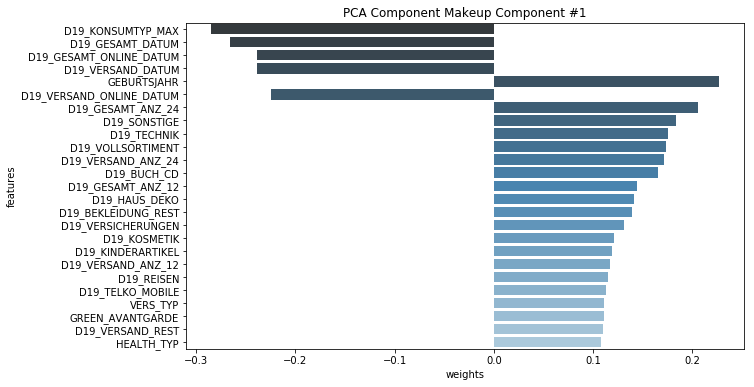

In [25]:
display_component(v, df.columns.values, component_num=1, n_weights=25)

In [ ]:
training_job_name = pca.latest_training_job.name
training_job_name

In [ ]:
attached_estimator = pca.attach(training_job_name)

In [ ]:
%%time

# pca_predictor = pca.deploy(initial_instance_count=1, instance_type='ml.t2.medium')
pca_predictor = attached_estimator.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

In [ ]:
%%time

#try chunking data to PCA endpoint
train_pca = []

for chunk in np.array_split(train_data_np, 5000):
    train_pca.append(pca_predictor.predict(chunk))

In [ ]:
flattened_train_pca = [list for sublist in train_pca for list in sublist]
del train_pca

In [ ]:
def create_transformed_df(flattened_train_pca, scaled_df, n_top_components):
    start_idx = N_COMPONENTS - n_top_components
    new_values = [x.label['projection'].float32_tensor.values for x in flattened_train_pca]
    df = pd.DataFrame(index=scaled_df.index.values, data=new_values)
    
    top_components = df.iloc[:,start_idx:]
    return top_components.iloc[:,::-1]

In [ ]:
flattened_train_pca = flattened_train_pca[:-1]
len(flattened_train_pca)

In [ ]:
df = df[:-1]
df.shape[0]

In [ ]:
len(flattened_train_pca) == df.shape[0]

In [ ]:
import numpy as np
set1, set2, set3, set4 = np.array_split(flattened_train_pca, 4)

In [ ]:
print(len(set1))
print(len(set2))
print(len(set3))
print(len(set4))

In [ ]:
%%time

import math
start_idx = 668415
end_idx = 891220
chunk_num = 4

top_n=5
cols = ['c1', 'c2', 'c3', 'c4', 'c5']


print('beginning', start_idx, end_idx)
print('scaled df index values: %.2d and x shape %.2d' % (df.iloc[start_idx:end_idx].shape[0], set1.shape[0]))
print()
df_transformed = create_transformed_df(set1, df.iloc[start_idx:end_idx], n_top_components=top_n)
df_transformed.columns = cols

file_name = '{}_transformed.csv'.format(chunk_num)
print(file_name)
df_transformed.to_csv(file_name)

In [ ]:
print(df.iloc[0:222805].shape[0])
print(df.iloc[222805:445610].shape[0])
print(df.iloc[445610:668415].shape[0])
print(df.iloc[668415:891220].shape[0])
print(df.shape[0])

In [ ]:
len(flattened_train_pca)

In [ ]:
session.delete_endpoint(pca_predictor.endpoint)

### KMeans Training

In [ ]:
df1_transformed = pd.read_csv('1_transformed.csv')

In [ ]:
df2_transformed = pd.read_csv('2_transformed.csv')

In [ ]:
df3_transformed = pd.read_csv('3_transformed.csv')

In [ ]:
df4_transformed = pd.read_csv('4_transformed.csv')

In [ ]:
df1_transformed = df1_transformed.append(df4_transformed)
print(df1_transformed.shape[0])

del df4_transformed

In [ ]:
df1_transformed = df1_transformed.drop('Unnamed: 0', axis=1)
df1_transformed.head()

In [ ]:
# KMeans

from sagemaker import KMeans

prefix = 'segmentation'
output_path = 's3://{}/{}/'.format(bucket, prefix)
print(output_path)

In [ ]:
kmeans = KMeans(
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.xlarge',
    output_path=output_path,
    sagemaker_session=session,
    k=8
)

In [ ]:
%%time
train_data_np = df1_transformed.values.astype('float32')
formatted_train_data = kmeans.record_set(train_data_np)

In [ ]:
%%time
kmeans.fit(formatted_train_data, logs=True)

In [ ]:
print(kmeans)

In [ ]:
%%time
kmeans_predictor = kmeans.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

In [ ]:
%%time

#try chunking data to PCA endpoint
cluster_info = []

#is this appending as expected?

for chunk in np.array_split(train_data_np, 2000):
    cluster_info.append(kmeans_predictor.predict(chunk))

In [ ]:
len(cluster_info)

In [ ]:
#explore clusters
data_idx = 1

# print(df1_transformed.index[data_idx])
# cluster_info[data_idx]

In [ ]:
flattened_cluster_info = [list for sublist in cluster_info for list in sublist]

In [ ]:
len(flattened_cluster_info)

In [ ]:
flattened_cluster_info[:1]

In [ ]:
cluster_labels = [c.label['closest_cluster'].float32_tensor.values[0] for c in flattened_cluster_info]

In [ ]:
cluster_df = pd.DataFrame(cluster_labels)[0].value_counts()
cluster_df.to_csv('german_cluster_df_6.csv')
print('Cluster Membership')
print(cluster_df)

In [ ]:
session.delete_endpoint(kmeans_predictor.endpoint)